## Weighted Age Analysis by Sex

### Objective

This notebook analyses population data by age and sex in Ireland, computing weighted descriptive statistics — mean, median, and standard deviation — using official CSO data.

### Setup Imports and file paths are consolidated for clarity and maintainability.

In [ ]:
# 📦 Essential imports for data analysis and visualization
import pandas as pd  # Core library for structured data manipulation (e.g., DataFrames)
import numpy as np  # Provides numerical operations, especially for arrays and statistical functions
import os  # Enables interaction with the operating system (e.g., file paths, environment variables)
import matplotlib.pyplot as plt  # Primary plotting library for visualizing data
from matplotlib.container import BarContainer  # Used to access and label individual bars in bar plots
from IPython.display import display  # Allows clean display of DataFrames and outputs in Jupyter notebooks
from pathlib import Path  # Modern, object-oriented approach to handling file system paths

# 📌 Notebook-wide configuration constants (adjust here to affect all plots and outputs)
OUTPUT_DPI = 150  # Controls resolution of saved figures (higher = sharper images)
DEFAULT_FIGSIZE = (9, 5)  # Sets default plot size for consistency across visualizations
KDE_BW_MULTIPLIER = 1.0  # Bandwidth multiplier for KDE plots; tweak for smoothing experiments

# 📁 Define and prepare the output directory for saving plots and data
SAVED_PLOTS_DIR = Path('../data').resolve()  # Canonical path for saving outputs (relative to notebook)
SAVED_PLOTS_DIR.mkdir(parents=True, exist_ok=True)  # Ensures directory exists; creates it if missing

# 📂 Define the main data directory used throughout the notebook
DATA_DIR = SAVED_PLOTS_DIR  # Use this variable in all file I/O operations for consistency

# 🧭 Legacy alias for compatibility with older code (prefer DATA_DIR going forward)
DATADIR = DATA_DIR  # Maintains backward compatibility with notebooks or scripts using DATADIR


In [ ]:
# Helper functions: plotting, loaders, and computation (keeps notebook cells concise)
# These functions assume the top-of-notebook imports and constants (plt, pd, np, OUTPUT_DPI, DEFAULT_FIGSIZE, KDE_BW_MULTIPLIER, DATA_DIR)

# ---------- 📤 Utility function for saving and displaying plots ----------

from pathlib import Path as _Path

def save_and_show(out_fp=None, dpi=OUTPUT_DPI):
    """
    Saves the current matplotlib figure to disk (if a file path is provided) and displays it.
    
    Why it's useful:
    - Ensures visual outputs are preserved for reports, assessments, or future reference.
    - Supports both string and Path inputs, making it flexible for different workflows.
    - Automatically creates the output directory if it doesn't exist.
    - Displays the figure inline for immediate review in the notebook.
    
    Parameters:
    - out_fp (str or Path): Optional file path to save the figure.
    - dpi (int): Resolution of the saved image (dots per inch).
    """
    try:
        if out_fp:
            # Accepts either a string or Path object
            p = _Path(out_fp)
            # Create parent directories if they don't exist
            p.parent.mkdir(parents=True, exist_ok=True)
            # Save the figure with tight bounding box
            plt.savefig(p, dpi=dpi, bbox_inches='tight')
            try:
                print('Saved figure to', str(p.resolve()))
            except Exception:
                print('Saved figure to', p)
    except Exception as _e:
        print('Could not save figure to', out_fp, '-', _e)
    # Always show the figure inline
    plt.show()

# ---------- 📁 I/O / Loader Helpers ----------

def load_pivot_from_csv(fp):
    """
    Loads a pivot-style CSV file and ensures the index (typically age) is numeric and sorted in ascending order.

    Why it's useful:
    - Ensures consistent data structure for downstream analysis (e.g. KDE, weighted stats).
    - Converts index values to integers, which is important for age-based computations.
    - Accepts both string paths and Path objects for flexibility.

    Parameters:
    - fp (str or Path): File path to the CSV file.

    Returns:
    - pd.DataFrame: A cleaned and sorted pivot table with numeric index.
    """
    fp = _Path(fp)  # Normalise to Path object
    df = pd.read_csv(fp, index_col=0)
    df.index = pd.Index(
        pd.to_numeric(df.index.to_series(), errors='coerce').fillna(0).astype(int)
    )
    df = df.sort_index()
    return df


def ensure_df_anal(in_memory_name='df_anal', csv_path=None):
    """
    Returns a pivot DataFrame from memory if it exists, otherwise loads it from a CSV file.

    Why it's useful:
    - Promotes reproducibility by allowing fallback to saved data.
    - Avoids reloading or recomputing data unnecessarily during notebook reruns.
    - Supports both in-memory workflows and file-based workflows.

    Parameters:
    - in_memory_name (str): Variable name to check in the global namespace.
    - csv_path (str or Path): Optional path to CSV file if in-memory variable is not found.

    Returns:
    - pd.DataFrame: Pivot table ready for analysis.

    Raises:
    - FileNotFoundError: If neither in-memory data nor a valid file path is provided.
    """
    if in_memory_name in globals():
        return globals()[in_memory_name].copy()

    if csv_path is None:
        raise FileNotFoundError('No in-memory pivot and no csv_path supplied')

    # Convert to absolute path if string
    if isinstance(csv_path, _Path):
        return load_pivot_from_csv(csv_path)
    if isinstance(csv_path, str):
        csv_path = os.path.abspath(csv_path)
        return load_pivot_from_csv(csv_path)

    # Fallback: attempt to load as-is
    return load_pivot_from_csv(csv_path)

# ---------- 📐 Statistical Computation Helper ----------

def compute_weighted_mean_std(pivot):
    """
    Computes the weighted mean and standard deviation of age for each group (e.g. sex) in a pivot table.

    Why it's useful:
    - Provides a summary of central tendency and spread, accounting for population size.
    - Essential for parametric visualisations such as bell curves.
    - Helps instructors and students interpret age distributions more accurately.

    Parameters:
    - pivot (pd.DataFrame): A pivot table where rows represent age and columns represent groups (e.g. sex),
      with cell values indicating population counts.

    Returns:
    - pd.DataFrame: Indexed by group (e.g. sex), with columns:
        - total_population: Sum of weights (i.e. total count for that group)
        - weighted_mean_age: Average age weighted by population
        - weighted_std_age: Standard deviation of age, also weighted
    """
    results = []

    for sex in pivot.columns:
        # Extract weights (population counts) and age values
        weights = pivot[sex].fillna(0).astype(float)
        ages = pivot.index.astype(float)
        total = weights.sum()

        if total > 0:
            # Weighted mean: average age accounting for population
            wmean = float(np.average(ages, weights=weights))
            # Weighted variance and standard deviation
            wvar = float(np.average((ages - wmean) ** 2, weights=weights))
            wstd = float(np.sqrt(wvar))
            total_int = int(total)
        else:
            # Handle empty or zero-weight groups gracefully
            wmean = float('nan')
            wstd = float('nan')
            total_int = 0

        results.append((sex, total_int, wmean, wstd))

    # Construct results DataFrame
    df = pd.DataFrame(
        results,
        columns=['sex', 'total_population', 'weighted_mean_age', 'weighted_std_age']
    ).set_index('sex')

    # Ensure numeric types for downstream compatibility
    df['weighted_mean_age'] = pd.to_numeric(df['weighted_mean_age'], errors='coerce').astype(float)
    df['weighted_std_age'] = pd.to_numeric(df['weighted_std_age'], errors='coerce').astype(float)
    df['total_population'] = pd.to_numeric(df['total_population'], errors='coerce').fillna(0).astype(int)

    return df

def compute_weighted_median(pivot):
    """
    Computes the weighted median age for each group (e.g. sex) in a pivot table.

    Why it's useful:
    - The weighted median identifies the age at which half the population (by count) is younger and half is older.
    - Unlike the mean, it is robust to skewed distributions or outliers.
    - Essential for demographic summaries where central tendency must reflect actual population structure.

    Parameters:
    - pivot (pd.DataFrame): A pivot table where rows represent age and columns represent groups (e.g. sex),
      with cell values indicating population counts.

    Returns:
    - pd.DataFrame: Indexed by group (e.g. sex), with one column:
        - weighted_median_age: The age at which cumulative population reaches 50% of the total.
    """
    median_results = []

    for sex in pivot.columns:
        # Extract weights (population counts) and age values
        weight_series = pivot[sex].fillna(0).astype(float)
        age_index = pivot.index.astype(float)
        weight_values = weight_series.to_numpy()

        if weight_values.sum() > 0:
            # Define the halfway point of the total population
            cutoff = weight_values.sum() / 2.0
            # Compute cumulative sum to find where the 50% threshold is crossed
            cumsum = weight_series.cumsum()
            mask = cumsum >= cutoff
            if mask.any():
                # First age where cumulative population exceeds 50%
                wmedian = float(age_index[mask][0])
            else:
                wmedian = np.nan
        else:
            # Handle empty or zero-weight groups
            wmedian = np.nan

        median_results.append((sex, wmedian))

    # Construct results DataFrame
    median_df = pd.DataFrame(
        median_results,
        columns=['sex', 'weighted_median_age']
    ).set_index('sex')

    return median_df


# ---------- 📊 Plotting Helpers (Parametric and KDE) ----------

def plot_parametric_bell(df_stats, out_fp=None, figsize=DEFAULT_FIGSIZE):
    """
    Plots parametric Gaussian (normal) curves for each group using weighted mean and standard deviation.

    Why it's useful:
    - Provides a simplified visual approximation of age distribution assuming normality.
    - Helps students interpret spread and central tendency using familiar bell curves.
    - Useful for comparing demographic groups side-by-side.

    Parameters:
    - df_stats (pd.DataFrame): Must contain 'weighted_mean_age' and 'weighted_std_age' for each group.
    - out_fp (str or Path): Optional file path to save the figure.
    - figsize (tuple): Size of the plot in inches.

    Raises:
    - ValueError: If the input DataFrame is empty or missing required columns.
    """
    if df_stats is None or df_stats.shape[0] == 0:
        raise ValueError('df_stats is empty; provide a DataFrame with mean/std rows')

    plt.figure(figsize=figsize)
    x_min, x_max = None, None

    for sex in df_stats.index:
        mu = df_stats.at[sex, 'weighted_mean_age']
        sigma = df_stats.at[sex, 'weighted_std_age']

        # Ensure values are valid floats
        try:
            mu = float(mu.real) if isinstance(mu, complex) else float(mu)
            sigma = float(sigma.real) if isinstance(sigma, complex) else float(sigma)
        except Exception:
            print(f"Skipping {sex}: mu/sigma not convertible to float (mu={mu}, sigma={sigma})")
            continue

        # Skip invalid or zero standard deviation
        if not (np.isfinite(mu) and np.isfinite(sigma) and sigma > 0):
            print(f"Skipping {sex}: invalid mu/sigma (mu={mu}, sigma={sigma})")
            continue

        # Define x-axis range based on spread
        span = max(4 * sigma, 10)
        x = np.linspace(mu - span, mu + span, 400)

        # Gaussian formula
        y = (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        plt.plot(x, y, label=f"{sex} (μ={mu:.2f}, σ={sigma:.2f})")

        # Track global x-axis limits
        x_min = x.min() if x_min is None else min(x_min, x.min())
        x_max = x.max() if x_max is None else max(x_max, x.max())

    plt.title('Approximate Normal (Bell) Curves by Sex')
    plt.xlabel('Age (years)')
    plt.ylabel('Density (approx.)')
    if x_min is not None and x_max is not None:
        plt.xlim(x_min, x_max)
    plt.legend()
    plt.grid(alpha=0.3)
    save_and_show(out_fp)


def compute_and_plot_kde(pivot, out_fp=None, figsize=DEFAULT_FIGSIZE, xgrid=None, bw_multiplier=KDE_BW_MULTIPLIER):
    """
    Computes and plots a weighted Kernel Density Estimate (KDE) for each group.

    Why it's useful:
    - KDE is a non-parametric method for estimating the shape of a distribution.
    - Unlike bell curves, KDE adapts to the actual data without assuming normality.
    - Bandwidth is auto-scaled but can be adjusted for experimentation.

    Parameters:
    - pivot (pd.DataFrame): Age-indexed pivot table with population counts per group.
    - out_fp (str or Path): Optional file path to save the figure.
    - figsize (tuple): Size of the plot in inches.
    - xgrid (np.ndarray): Optional grid of age values for KDE evaluation.
    - bw_multiplier (float): Multiplier to adjust bandwidth sensitivity.

    Returns:
    - tuple: (xgrid, densities) where densities is a dictionary of KDE curves per group.
    """
    if pivot is None or pivot.shape[0] == 0:
        raise ValueError('pivot is empty; create df_anal or provide a pivot DataFrame')

    # Ensure index is numeric and sorted
    pivot.index = pd.Index(pd.to_numeric(pivot.index.to_series(), errors='coerce').fillna(0).astype(float))
    pivot = pivot.sort_index()

    # Define x-axis grid
    x_min, x_max = pivot.index.min(), pivot.index.max()
    if xgrid is None:
        xgrid = np.linspace(x_min, x_max, 800)

    plt.figure(figsize=figsize)
    densities = {}

    for sex in pivot.columns:
        weights = pivot[sex].fillna(0).astype(float).to_numpy()
        ages = pivot.index.to_numpy().astype(float)
        total = weights.sum()

        if total <= 0:
            print(f"Skipping {sex}: no data")
            continue

        # Estimate bandwidth using Silverman's rule-of-thumb
        wmean = (weights * ages).sum() / total
        wvar = (weights * (ages - wmean) ** 2).sum() / total
        wstd = np.sqrt(wvar) if np.isfinite(wvar) and wvar > 0 else max(1.0, np.std(ages))
        bw = bw_multiplier * (1.06 * wstd * total ** (-1 / 5) if total > 1 else max(1.0, wstd))
        bw = max(bw, 0.5)  # Prevent overly narrow bandwidths

        # Compute Gaussian kernels across the grid
        X = xgrid[:, None]  # Grid for evaluation
        A = ages[None, :]   # Age values
        Z = (X - A) / bw
        kernel = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * Z ** 2)
        density = (kernel * weights[None, :]).sum(axis=1) / (total * bw)

        densities[sex] = density
        plt.plot(xgrid, density, label=f"{sex} (KDE, bw={bw:.2f})")

    plt.title('Weighted KDE of Age by Sex (using actual counts)')
    plt.xlabel('Age (years)')
    plt.ylabel('Estimated density')
    plt.grid(alpha=0.25)
    plt.legend()
    save_and_show(out_fp)
    return xgrid, densities



### Filename and Data Directory Setup

In [ ]:
# ---------- 📂 Notebook Setup: Paths and Display Options ----------

# Derive the current working directory (useful for relative path resolution)
notebook_dir = os.getcwd()

# Ensure the data output directory exists on disk
# This is important for saving plots, outputs, or derived files
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Define the canonical filename and its full path for reading/writing data
FILENAME = "population_for_analysis.csv"
FULLPATH = DATA_DIR / FILENAME  # Combines directory and filename using Path

# Set notebook display preferences for DataFrames
# Limits the number of rows shown to avoid overwhelming output
pd.options.display.max_rows = 20

# Confirm paths for transparency and debugging
print("Base data directory:", str(DATA_DIR))
print("Using FULLPATH for pivot/read:", str(FULLPATH))



Base data directory: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data
Using FULLPATH for pivot/read: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\population_for_analysis.csv


### Run this notebook: quick checklist

Please run cells in order. If you restart the kernel, re-run the cells listed below before running the analysis/plotting cells.

1. Setup imports & paths (top of notebook)
2. Load dataset (the cell that fetches/saves `population_for_analysis.csv`)
3. Data cleaning cell (converts age labels, filters sexes)
4. Pivot: create `df_anal` and save `weighted_stats_by_sex.csv` (run this before KDE)
5. Compute weighted mean/std: creates `weighted_mean_std_by_sex.csv` (run this before bell-curve)
6. Bell-curve & KDE plotting cells (produce PNGs in `../data/`)

Notes:
- Expected output files (in `../data/`): `weighted_stats_by_sex.csv`, `weighted_mean_std_by_sex.csv`, `assignment-05-age-bell-curve.png`, `assignment-05-age-kde.png`, `age_difference_by_sex.csv`
- If you have no Internet access, run the file-loading cell only if you have a local copy of `population_for_analysis.csv` available in `../data/`.


### Load Dataset

In [ ]:
# ---------- 📥 Fetch and Save Population Data from CSO API ----------

# Define the API endpoint for the CSO population dataset (FY006A)
url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en"
print('Fetching raw data from URL:', url)

# Read the CSV-formatted dataset directly from the API
# This returns a full population table with age and sex breakdowns
df = pd.read_csv(url)

# Ensure the data directory exists before saving
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Define the full output path using Path object
fullpath = FULLPATH  # Already defined earlier in the notebook

# Save the raw dataset to disk for reproducibility and later inspection
# pandas accepts Path objects directly
df.to_csv(fullpath, index=False)
print('Saved raw population data to', str(fullpath.resolve()))

# 🧾 Verify the saved file by reading it back and displaying the last few rows
# This confirms that the file was written correctly and is readable
saved_df = pd.read_csv(fullpath)
try:
    display(saved_df.tail(3))  # Show last 3 rows for quick inspection
except Exception:
    print('Could not display tail of raw data; file saved at', str(fullpath.resolve()))



Fetching raw data from URL: https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en
Saved raw population data to C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\population_for_analysis.csv
Saved raw population data to C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\population_for_analysis.csv


,STATISTIC,Statistic Label,TLIST(A1),CensusYear,C02199V02655,Sex,C02076V03371,Single Year of Age,C03789V04537,Administrative Counties,UNIT,VALUE
9789,FY006AC01,Population,2022,2022,2,Female,650,100 years and over,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,12
9790,FY006AC01,Population,2022,2022,2,Female,650,100 years and over,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,31
9791,FY006AC01,Population,2022,2022,2,Female,650,100 years and over,2ae19629-1495-13a3-e055-000000000001,Monaghan County Council,Number,7


### View Column Names

In [5]:
headers = df.columns.tolist()
headers

['STATISTIC',
 'Statistic Label',
 'TLIST(A1)',
 'CensusYear',
 'C02199V02655',
 'Sex',
 'C02076V03371',
 'Single Year of Age',
 'C03789V04537',
 'Administrative Counties',
 'UNIT',
 'VALUE']

### Extract Gender Based Data From Saved File

In [ ]:
# ---------- 📥 Load and Clean Raw Population Data ----------

# Read the raw dataset from the saved CSV file
print("Reading raw file from:", os.path.abspath(FULLPATH))
df = pd.read_csv(FULLPATH)

# 🧹 Drop metadata or identifier columns that are not needed for analysis
# These may vary depending on the CSO export format
drop_cols = [
    'STATISTIC', 'Statistic Label', 'TLIST(A1)', 'CensusYear',
    'C02199V02655', 'C02076V03371', 'C03789V04537', 'Administrative Counties', 'UNIT'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 🧑‍🤝‍🧑 Keep only rows for Male and Female (exclude 'Both sexes' or other categories)
df = df[df['Sex'].isin(['Male', 'Female'])]

# 🔢 Clean and standardise age labels
# - Remove 'All ages' summary row
# - Replace 'Under 1 year' with '0'
# - Remove any remaining non-digit characters (e.g. ' years')
df = df[df['Single Year of Age'] != 'All ages']
df['Single Year of Age'] = df['Single Year of Age'].str.replace('Under 1 year', '0')
df['Single Year of Age'] = df['Single Year of Age'].str.replace(r'\D', '', regex=True)

# 🔧 Convert cleaned columns to numeric types
df['Single Year of Age'] = df['Single Year of Age'].astype(int)
df['VALUE'] = df['VALUE'].astype(int)

# 📊 Display the structure of the cleaned DataFrame
# This confirms column types and row count for downstream use
df.info()


Reading raw file from: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\population_for_analysis.csv
<class 'pandas.core.frame.DataFrame'>
Index: 6464 entries, 3296 to 9791
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Sex                 6464 non-null   object
 1   Single Year of Age  6464 non-null   int64 
 2   VALUE               6464 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 202.0+ KB


### Write Weighted Statistics By Gender to CSV File

In [ ]:
# ---------- 📈 Pivot Table: Age vs Sex ----------

# Create a pivot table where:
# - Rows represent individual ages
# - Columns represent sex (Male, Female)
# - Cell values represent population counts
df_anal = pd.pivot_table(df, values='VALUE', index='Single Year of Age', columns='Sex')

# Sort the age index to ensure ascending order for analysis and plotting
df_anal = df_anal.sort_index()

# 💾 Save the pivot table to disk for reproducibility and future use
output_path = DATA_DIR / "weighted_stats_by_sex.csv"
df_anal.to_csv(output_path)
print("\nSaved pivot table to:", str(output_path.resolve()))

# 👀 Display a preview of the pivot table (first few rows)
# This helps verify structure before proceeding with analysis
try:
    display(df_anal.head())
except:
    print("Preview unavailable; pivot saved to:", str(output_path.resolve()))



Saved pivot table to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\weighted_stats_by_sex.csv


Sex,Female,Male
Single Year of Age,,
0,1761.6250,1850.6250
1,1721.5625,1804.6875
2,1810.8750,1889.7500
3,1842.6875,1937.5625
4,1863.6875,1980.3750


In [ ]:
# ---------- ✅ Sanity Check: Pivot Table Validation ----------

# This block should be run immediately after creating the pivot table `df_anal`.
# It verifies that the pivot exists, has a sensible age index, and includes expected sex columns.

# Check if the pivot exists in memory
if 'df_anal' in globals():
    pivot = df_anal.copy()
else:
    # If not in memory, attempt to load it from disk
    pivot_fp = DATA_DIR / 'weighted_stats_by_sex.csv'
    if pivot_fp.exists():
        pivot = load_pivot_from_csv(pivot_fp)
    else:
        pivot = None

# Validate the pivot structure
if pivot is None or pivot.shape[0] == 0:
    print('Sanity check FAILED: pivot `df_anal` is empty or not found. Run the pivot cell that creates `df_anal`.')
else:
    print('Sanity check OK: pivot found with', pivot.shape[0], 'age rows and', pivot.shape[1], 'columns')
    
    # Display a preview of the pivot table
    try:
        display(pivot.head())
    except Exception:
        print(pivot.head().to_string())

    # Show the age range in the index
    print('\nIndex (age) min/max:', pivot.index.min(), '/', pivot.index.max())

    # Confirm expected sex columns are present
    expected_sexes = ['Male', 'Female']
    missing = [s for s in expected_sexes if s not in pivot.columns]
    if missing:
        print('Warning: expected sex columns missing from pivot:', missing)
    else:
        print('Pivot contains expected sex columns:', expected_sexes)


Sanity check OK: pivot found with 101 age rows and 2 columns


Sex,Female,Male
Single Year of Age,,
0,1761.6250,1850.6250
1,1721.5625,1804.6875
2,1810.8750,1889.7500
3,1842.6875,1937.5625
4,1863.6875,1980.3750



Index (age) min/max: 0 / 100
Pivot contains expected sex columns: ['Male', 'Female']


### Weighted Mean Age by Sex (Using NumPy)

# 📊 Weighted Mean Explained

The weighted mean is a statistical measure that calculates the average of a set of values, where each value contributes proportionally to its assigned weight. Unlike the arithmetic mean, which treats all values equally, the weighted mean adjusts for the relative importance, frequency, or reliability of each observation. *see README for further explanation.*


- [Pandas Documentation on Weighted Mean](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html)
- [Numpy Documentation on Average](https://numpy.org/doc/stable/reference/generated/numpy.average.html)
- [Pandas Documentation on Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)


In [ ]:
# ---------- 🧮 Compute and Save Weighted Mean & Standard Deviation ----------

# 📁 Define the file path for the pivot table (set earlier in the notebook)
filepath = output_path  # output_path is a Path object created during pivot step

# 📥 Load the pivot table from disk
# pandas supports Path objects directly
df_anal = pd.read_csv(filepath, index_col=0)

# 🧮 Compute weighted mean and standard deviation for each group (e.g. sex)
results = []
for sex in df_anal.columns:
    weights = df_anal[sex].fillna(0).astype(float)  # Population counts
    ages = df_anal.index.astype(float)              # Age values from index

    if weights.sum() > 0:
        # Weighted mean: average age weighted by population
        wmean = float(np.average(ages, weights=weights))
        # Weighted variance and standard deviation
        wvar = float(np.average((ages - wmean) ** 2, weights=weights))
        wstd = float(np.sqrt(wvar))
        total = int(weights.sum())
        print(f"{sex}: Weighted mean age = {wmean:.2f}, weighted std = {wstd:.2f}")
    else:
        # Handle empty or zero-weight groups
        wmean = float('nan')
        wstd = float('nan')
        total = 0
        print(f"{sex}: No population data available")

    results.append((sex, total, wmean, wstd))

# 📊 Create a DataFrame from the results
mean_std_df = pd.DataFrame(
    results,
    columns=['sex', 'total_population', 'weighted_mean_age', 'weighted_std_age']
).set_index('sex')

# 🔧 Ensure correct data types before saving
mean_std_df['weighted_mean_age'] = pd.to_numeric(mean_std_df['weighted_mean_age'], errors='coerce').astype(float)
mean_std_df['weighted_std_age'] = pd.to_numeric(mean_std_df['weighted_std_age'], errors='coerce').astype(float)
if 'total_population' in mean_std_df.columns:
    mean_std_df['total_population'] = pd.to_numeric(mean_std_df['total_population'], errors='coerce').fillna(0).astype(int)

# 💾 Save the summary statistics to CSV
mean_std_filename = 'weighted_mean_std_by_sex.csv'
mean_std_path = DATA_DIR / mean_std_filename
DATA_DIR.mkdir(parents=True, exist_ok=True)
mean_std_df.to_csv(mean_std_path)
print('\nSaved weighted mean & std to', str(mean_std_path.resolve()))

# 👀 Display the results and data types for verification
try:
    display(mean_std_df)
except Exception:
    print(mean_std_df.to_string())

print('\nDtypes:')
print(mean_std_df.dtypes)


Female: Weighted mean age = 38.94, weighted std = 23.00
Male: Weighted mean age = 37.74, weighted std = 22.67

Saved weighted mean & std to C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\weighted_mean_std_by_sex.csv


,total_population,weighted_mean_age,weighted_std_age
sex,,,
Female,162786,38.939796,22.998990
Male,159034,37.739448,22.671204



Dtypes:
total_population       int64
weighted_mean_age    float64
weighted_std_age     float64
dtype: object


In [ ]:
# ---------- 🔁 Quick Verification: Re-read Saved Weighted Stats ----------

# Re-read the CSV file we just saved to confirm its structure and contents.
# This step is especially useful for students to verify that the file was written correctly.

if mean_std_path.exists():
    # Load the saved file
    df_check = pd.read_csv(mean_std_path, index_col=0)

    # Coerce column types defensively to ensure numeric integrity
    df_check['weighted_mean_age'] = pd.to_numeric(df_check['weighted_mean_age'], errors='coerce').astype(float)
    df_check['weighted_std_age'] = pd.to_numeric(df_check['weighted_std_age'], errors='coerce').astype(float)
    if 'total_population' in df_check.columns:
        df_check['total_population'] = pd.to_numeric(df_check['total_population'], errors='coerce').fillna(0).astype(int)

    print('\nRe-read and verified saved CSV:')
    try:
        display(df_check)  # Show full table if supported
    except Exception:
        print(df_check)    # Fallback to plain text

    print('\nDtypes:')
    print(df_check.dtypes)

    # ✅ Lightweight checks to confirm readiness for plotting
    if not set(['weighted_mean_age', 'weighted_std_age']).issubset(df_check.columns):
        print('Warning: expected columns missing from saved CSV. Re-run the mean/std computation cell.')
    else:
        if not np.isfinite(df_check['weighted_mean_age']).any():
            print('Warning: weighted_mean_age contains no finite values; check pivot input.')
        else:
            print('weighted_mean_age and weighted_std_age appear numeric. Good to proceed to plotting cells.')
else:
    print('Expected file not found:', str(mean_std_path))



Re-read and verified saved CSV:


,total_population,weighted_mean_age,weighted_std_age
sex,,,
Female,162786,38.939796,22.998990
Male,159034,37.739448,22.671204



Dtypes:
total_population       int64
weighted_mean_age    float64
weighted_std_age     float64
dtype: object
weighted_mean_age and weighted_std_age appear numeric. Good to proceed to plotting cells.


# Normal Distribution

![XKCD Comic](https://imgs.xkcd.com/comics/normal_distribution_2x.png)

This comic image humorously illustrates the concept of a normal distribution, highlighting the common misconception that data should always fit a perfect bell curve. In reality, many datasets exhibit variations and deviations from this idealized shape, reminding us that statistical distributions can be complex and diverse.

source: [XKCD Comic on Normal Distribution](https://xkcd.com/221/)

### Bell-curve (normal) plot using weighted mean & std
Below we plot an approximate normal (Gaussian) density for each sex using the weighted mean (μ) and weighted standard deviation (σ) previously computed and saved to `weighted_mean_std_by_sex.csv`.

This parametric (analytic) plot is intended as a simple visual comparison between sexes, but real age distributions are often skewed or multi-modal.

To provide a more data-driven view, the next cell computes a weighted KDE using the actual single-year age counts from the pivot (`df_anal` or `weighted_stats_by_sex.csv`) and saves a smoothed density plot to `assignment-05-age-kde.png`.

Execution order: run the pivot cell (which creates `df_anal`), then the weighted mean/std cell (which writes `weighted_mean_std_by_sex.csv`), and finally run these plotting cells (bell-curve and KDE) to produce the PNG outputs:
- `assignment-05-age-bell-curve.png` (parametric normal curves)
- `assignment-05-age-kde.png` (data-driven weighted KDE)

Use the KDE when you want a realistic shape derived from the counts; keep the bell-curve for a concise parametric comparison.

Saved figure to C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment-05-age-bell-curve.png


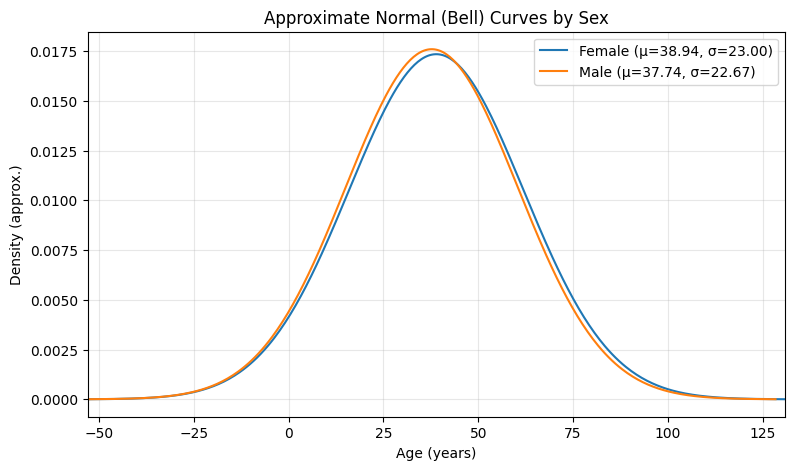

In [ ]:
# ---------- 📈 Plot Parametric Bell Curves Using Weighted Mean & Standard Deviation ----------

# Prefer the in-memory DataFrame `mean_std_df` if available
# This avoids unnecessary file I/O during notebook reruns
if 'mean_std_df' in globals():
    df_stats = mean_std_df.copy()
else:
    # Fallback: read the saved summary statistics from disk
    stats_fp = DATA_DIR / 'weighted_mean_std_by_sex.csv'
    if stats_fp.exists():
        df_stats = pd.read_csv(stats_fp, index_col=0)
    else:
        raise FileNotFoundError('weighted_mean_std_by_sex.csv not found; run the weighted mean/std cell first')

# 🔧 Coerce columns to numeric types to ensure clean plotting
# Non-numeric entries are converted to NaN and handled gracefully
df_stats['weighted_mean_age'] = pd.to_numeric(df_stats['weighted_mean_age'], errors='coerce').astype(float)
df_stats['weighted_std_age']  = pd.to_numeric(df_stats['weighted_std_age'],  errors='coerce').astype(float)

# 📊 Use the helper function to generate and save the bell-curve plot
# This visualises the approximate normal distribution of age for each sex group
out_fp = DATA_DIR / 'assignment-05-age-bell-curve.png'
plot_parametric_bell(df_stats, out_fp=out_fp)


### Key observations in Bell-Curve Plot

The plot draws a Normal (Gaussian) curve for each sex using the weighted mean (μ) and weighted standard deviation (σ).

Both curves peak near the same age (means are very close) and have similar spread (σ ≈ 23), so the two distributions largely overlap — men and women have similar age structure in this dataset.

Small differences (tiny horizontal shift or height) reflect slight differences in mean/std but are not large.


**How this connects to the normal-distribution image (the joke)**

The bell-curve is a tidy parametric summary: it assumes the data are symmetric and single-peaked (the ideal “normal” bell in the comic).

The XKCD image jokes that real data aren’t always that neat — it’s a reminder to check the actual data shape.

In this notebook the KDE (data-driven curve) and the bell-curve are very similar, so the Normal approximation is reasonable here — but we still inspect the KDE first to catch skew or extra bumps that a simple bell might hide.

- seaborn.kdeplot — convenient KDE plotting: https://seaborn.pydata.org/generated/seaborn.kdeplot.html
- Normal distribution (definition & PDF used for bell-curve): https://en.wikipedia.org/wiki/Normal_distribution
- Weighted mean & variance (formulas): https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
- Weighted median explanation (background): https://real-statistics.com/descriptive-statistics/measures-central-tendency/weighted-mean-and-median/
- CSO FY006A data source (raw population table used): https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en
- XKCD comic (reminder that real data can be messy): https://xkcd.com/221/

### Weighted KDE of Age by Sex
This cell computes a weighted Kernel Density Estimate (KDE) of age

Saved figure to C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment-05-age-kde.png


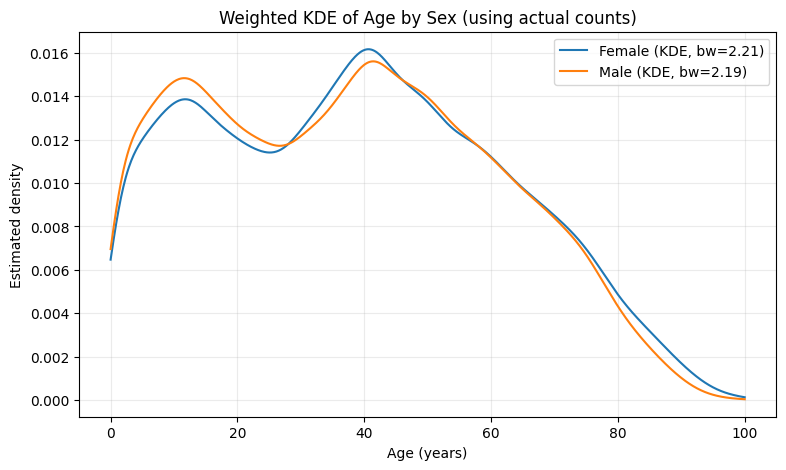


🔍 Preview: First 10 KDE values per sex

Female KDE preview:


,age,density
0,0.000000,0.006469
1,0.125156,0.006718
2,0.250313,0.006963
3,0.375469,0.007205
4,0.500626,0.007443
5,0.625782,0.007676
6,0.750939,0.007903
7,0.876095,0.008125
8,1.001252,0.008341
9,1.126408,0.008550



Male KDE preview:


,age,density
0,0.000000,0.006954
1,0.125156,0.007224
2,0.250313,0.007490
3,0.375469,0.007752
4,0.500626,0.008009
5,0.625782,0.008261
6,0.750939,0.008508
7,0.876095,0.008747
8,1.001252,0.008980
9,1.126408,0.009206


In [ ]:
# ---------- 🔎 KDE Plot: Smoothed Age Density Using Actual Counts ----------

# Prefer the in-memory pivot table `df_anal` if available
# This avoids unnecessary file reads during notebook reruns
if 'df_anal' in globals():
    pivot = df_anal.copy()
else:
    # Fallback: read the saved pivot table from disk
    pivot_fp = DATA_DIR / 'weighted_stats_by_sex.csv'
    if pivot_fp.exists():
        pivot = pd.read_csv(pivot_fp, index_col=0)
    else:
        raise FileNotFoundError('Pivot table df_anal not in memory and weighted_stats_by_sex.csv not found; run the pivot cell first')

# 📊 Use the helper function to compute and plot weighted KDE
# This visualises the actual age distribution without assuming normality
kde_fp = DATA_DIR / 'assignment-05-age-kde.png'
xgrid, densities = compute_and_plot_kde(pivot, out_fp=kde_fp)

'''
# 👀 Display first 10 density values for each sex (Optional)
print("\n🔍 Preview: First 10 KDE values per sex")
for sex, density in densities.items():
    print(f"\n{sex} KDE preview:")
    preview_df = pd.DataFrame({'age': xgrid[:10], 'density': density[:10]})
    try:
        display(preview_df)
    except Exception:
        print(preview_df.to_string(index=False))
'''


### Key observations in Weighted KDE of Age by Sex

Both sexes show similar overall shapes — the two curves largely overlap — so age structure is similar between Female and Male in this dataset.

Noticeable peaks (example): a peak in younger ages (small children) and a broader hump around middle ages — these indicate common age groups.

Small differences between the curves (where one line is slightly above the other) highlight ages where one sex has a relatively higher proportion.

- pandas (reading & pivoting data): https://pandas.pydata.org/
- NumPy (numeric ops): https://numpy.org/
- Matplotlib (plotting): https://matplotlib.org/
- Kernel Density Estimation (concept + Gaussian kernel): https://en.wikipedia.org/wiki/Kernel_density_estimation
- Bandwidth selection (Scott’s and Silverman’s rules): https://en.wikipedia.org/wiki/Kernel_density_estimation#Choice_of_bandwidth
- SciPy / stats examples of KDE (practical): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html


## Weighted Median and Standard Deviation (by Sex)

When analysing age distributions across sexes (e.g., male and female), we often want to understand not just the average age, but also the central tendency (median) and spread (standard deviation) — especially when population counts vary across age groups.

### 🧮 Weighted Median

The **weighted median** is the age at which half of the weighted population is younger and half is older. It accounts for the number of individuals at each age, making it more robust than the mean when data is skewed. *see README for further explanation.*


- [NumPy `average()` method](https://numpy.org/doc/stable/reference/generated/numpy.average.html)  
  While NumPy does not directly support weighted medians, its `average()` method is commonly used for weighted means and forms the basis for computing weighted variance and standard deviation.

- [Real Statistics: Weighted Median](https://real-statistics.com/descriptive-statistics/measures-central-tendency/weighted-mean-and-median/)  
  Offers a clear explanation of how the weighted median is calculated, including step-by-step logic using cumulative weights and sorted values.

- [pandas Series API](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)  
  pandas provides `.median()` for Series and DataFrames, but does not natively support weighted medians. Custom logic using cumulative weights is required.


In [ ]:
# ---------- 🧮 Compute Weighted Median Age by Sex ----------

# This block calculates the weighted median age for each sex group.
# The weighted median is the age at which half the population (by count) is younger and half is older.

median_results = []

for sex in df_anal.columns:
    # Extract population weights and age index
    weight_series = df_anal[sex].fillna(0).astype(float)
    age_index = df_anal.index.astype(float)

    weight_values = weight_series.to_numpy()
    age_values = age_index.to_numpy()

    if weight_values.sum() > 0:
        # Define the halfway point of the total population
        cutoff = weight_values.sum() / 2.0
        # Compute cumulative sum to find where the 50% threshold is crossed
        cumsum = weight_series.cumsum()
        mask = cumsum >= cutoff
        if mask.any():
            # First age where cumulative population exceeds 50%
            wmedian = float(age_index[mask][0])
        else:
            wmedian = np.nan
    else:
        # Handle empty or zero-weight groups
        wmedian = np.nan

    median_results.append((sex, wmedian))

# 📊 Create a DataFrame to store the results
median_df = pd.DataFrame(
    median_results,
    columns=['sex', 'weighted_median_age']
).set_index('sex')

# Display the result
median_df


,weighted_median_age
sex,
Female,39.0
Male,38.0


### 📊 Weighted Standard Deviation

The **weighted standard deviation** measures how spread out the ages are, accounting for population size at each age. *see README for further explanation.*


- [NumPy `average()` method](https://numpy.org/doc/stable/reference/generated/numpy.average.html)  
  Used to compute weighted means and intermediate steps for weighted variance and standard deviation. Supports the `weights` parameter for efficient calculation.

- [Real Statistics: Weighted Mean and Standard Deviation](https://real-statistics.com/descriptive-statistics/measures-central-tendency/weighted-mean-and-median/)  
  Provides formulas and examples for computing weighted standard deviation, including the use of weighted variance as a precursor.

- [pandas Series API](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)  
  pandas supports `.std()` for standard deviation, but does not natively support weighted standard deviation. Custom logic using NumPy or manual weighting is required.


In [ ]:
# ---------- 🧮 Compute Weighted Standard Deviation by Sex ----------

# This block calculates the weighted standard deviation of age for each sex group.
# Standard deviation measures the spread of ages around the weighted mean, accounting for population size.

std_results = []

for sex in df_anal.columns:
    # Extract population weights and age index
    weight_series = df_anal[sex].fillna(0).astype(float)
    age_index = df_anal.index.astype(float)

    weight_values = weight_series.to_numpy()
    age_values = age_index.to_numpy()

    if weight_values.sum() > 0:
        # Compute weighted mean first
        wmean = np.average(age_values, weights=weight_values)
        # Then compute weighted standard deviation
        wstd = float(np.sqrt(np.average((age_values - wmean) ** 2, weights=weight_values)))
    else:
        # Handle empty or zero-weight groups
        wstd = np.nan

    std_results.append((sex, wstd))

# 📊 Create a DataFrame to store the results
std_df = pd.DataFrame(
    std_results,
    columns=['sex', 'weighted_std_age']
).set_index('sex')

# Display the result
std_df


,weighted_std_age
sex,
Female,22.998990
Male,22.671204


### Merge and Export Combined Results

In [ ]:
# ---------- 📁 Save Weighted Median and Standard Deviation by Sex ----------

# Define the output file path for the merged statistics
WEIGHTED_STATS_FILENAME = "weighted_median_std_by_sex.csv"
ws_path = os.path.join(DATADIR, WEIGHTED_STATS_FILENAME)

# Ensure the output directory exists
os.makedirs(DATADIR, exist_ok=True)

# 🔗 Merge the median and standard deviation DataFrames by sex
# This creates a compact summary table for downstream use or reporting
combined_df = median_df.join(std_df)

# 📤 Save the merged statistics to CSV
combined_df.to_csv(ws_path)
print("✅ Saved weighted median and std to:", os.path.abspath(ws_path))

# 👀 Display the merged results for verification
combined_df


✅ Saved weighted median and std to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\weighted_median_std_by_sex.csv


,weighted_median_age,weighted_std_age
sex,,
Female,39.0,22.998990
Male,38.0,22.671204


### Weighted Mean By Sex Difference Bar Chart

Plotting weighted means (loaded from: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\weighted_mean_std_by_sex.csv )
Saved mean-age bar plot to C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment-05-mean-age-bar.png


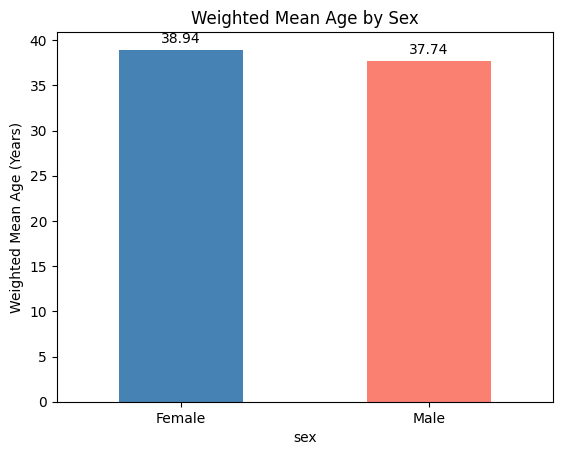

In [ ]:
# ---------- 📊 Bar Chart: Weighted Mean Age by Sex ----------

# Prefer pre-computed weighted means from CSV if available
mean_fp = DATA_DIR / 'weighted_mean_std_by_sex.csv'
means_series = None
loaded_from = None

# 🧮 Attempt to load weighted means from disk
if mean_fp.exists():
    df_stats = pd.read_csv(mean_fp, index_col=0)
    if 'weighted_mean_age' in df_stats.columns:
        means_series = df_stats['weighted_mean_age'].astype(float)
        loaded_from = str(mean_fp)

# 🔁 Fallback: compute weighted means from in-memory pivot table
if means_series is None and 'df_anal' in globals():
    pivot = df_anal.sort_index()
    means_calc = {}
    for sex in ['Male', 'Female']:
        if sex in pivot.columns:
            w = pivot[sex].fillna(0).astype(float)
            means_calc[sex] = np.average(pivot.index.astype(float), weights=w) if w.sum() > 0 else float('nan')
        else:
            means_calc[sex] = float('nan')
    means_series = pd.Series(means_calc, name='weighted_mean_age')
    loaded_from = 'df_anal (in-memory)'

# 🚫 If no data is available, inform the user
if means_series is None:
    print('No weighted mean data available. Run the mean computation cell (which writes weighted_mean_std_by_sex.csv) or create `df_anal` by running the pivot cell.')
else:
    print('Plotting weighted means (loaded from:', loaded_from, ')')

    # 📈 Create bar chart
    ax = means_series.plot(
        kind='bar',
        title='Weighted Mean Age by Sex',
        rot=0,
        color=['steelblue', 'salmon']
    )
    ax.set_ylabel('Weighted Mean Age (Years)')

    # 🏷️ Add value labels to each bar
    for container in ax.containers:
        if not isinstance(container, BarContainer):
            continue
        heights = [patch.get_height() for patch in container]
        labels = [f"{height:.2f}" if not pd.isna(height) else "NaN" for height in heights]
        ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontsize=10)

    # 💾 Save the figure to disk
    plot_fp = DATA_DIR / 'assignment-05-mean-age-bar.png'
    plt.savefig(plot_fp, dpi=150, bbox_inches='tight')
    print('Saved mean-age bar plot to', str(plot_fp.resolve()))
    plt.show()


## Difference between sexes in Age Groups

This cell builds a tidy CSV (`age_difference_by_sex.csv`) with age-by-age population counts and the difference (Male − Female).

How the cell works (summary):
- It uses the in-memory pivot `df_anal` created earlier (run the pivot cell that produces `df_anal` before running this cell).
- The pivot index is converted to numeric ages and rows are sorted by age.
- `Male` and `Female` counts are extracted; missing sex columns are filled with zeros to avoid errors.
- A tidy DataFrame is created with columns: `age`, `female`, `male`, `difference` (male − female), and `sex_greater_age_difference`.
- The DataFrame is written to `assignments/data/age_difference_by_sex.csv` and a small preview is displayed.

Inputs and outputs:
- Input: `df_anal` (pivot table; index = single-year ages; expected columns include `Male` and `Female`).
- Output: `assignments/data/age_difference_by_sex.csv` (tidy CSV with columns: `age`, `female`, `male`, `difference`, `sex_greater_age_difference`).

Notes for students and debugging tips:
- If you get a FileNotFoundError, run the pivot cell (the one that creates `df_anal`) first.
- If one sex column is missing, the code uses zeros for that sex and the `difference` will show the imbalance accordingly.
- The `sex_greater_age_difference` column contains `Male`, `Female`, or `Equal`.
- After running this cell, open `assignments/data/age_difference_by_sex.csv` to inspect age-specific differences in a spreadsheet or with pandas.

In [ ]:
# ---------- 🗃️ Create and Save Age Difference by Sex ----------

# Define the output filename for the age difference table
AGE_DIFF_FILENAME = "age_difference_by_sex.csv"

# ✅ Always use the in-memory pivot table `df_anal` to simplify student workflow
if 'df_anal' in globals():
    pivot = df_anal.copy()
else:
    raise FileNotFoundError('df_anal not found in memory; run the pivot cell that creates df_anal before running this cell')

# 🔧 Ensure the age index is numeric and sorted
pivot_index_numeric = pd.to_numeric(pivot.index.to_series(), errors='coerce').fillna(0).astype(int)
pivot.index = pd.Index(pivot_index_numeric, name=pivot.index.name)
pivot = pivot.sort_index()

# 🧑‍🤝‍🧑 Extract Male and Female series, defaulting to zero if missing
male_series = pivot.get('Male', pd.Series(0, index=pivot.index)).fillna(0).astype(int)
female_series = pivot.get('Female', pd.Series(0, index=pivot.index)).fillna(0).astype(int)

# 🧮 Build the output DataFrame
df_out = pd.DataFrame({
    'age': pivot.index.astype(int),
    'female': female_series.values,
    'male': male_series.values
})
df_out['difference'] = df_out['male'] - df_out['female']

# 🔍 Identify which sex has a greater count at each age
df_out['sex_greater_age_difference'] = np.where(
    df_out['male'] > df_out['female'], 'Male',
    np.where(df_out['female'] > df_out['male'], 'Female', 'Equal')
)

# 💾 Save the output to CSV
age_diff_fp = os.path.join(DATADIR, AGE_DIFF_FILENAME)
os.makedirs(DATADIR, exist_ok=True)
df_out.to_csv(age_diff_fp, index=False)
print('Saved age-difference CSV to', os.path.abspath(age_diff_fp))

# 👀 Display a preview of the output
try:
    display(df_out.head())
except Exception:
    print('Saved age-difference CSV to', os.path.abspath(age_diff_fp))


Saved age-difference CSV to C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\age_difference_by_sex.csv


,age,female,male,difference,sex_greater_age_difference
0,0,1761,1850,89,Male
1,1,1721,1804,83,Male
2,2,1810,1889,79,Male
3,3,1842,1937,95,Male
4,4,1863,1980,117,Male


### References & Exercises

References (short list). For a fuller list see README:
- CSO FY006A data: https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en
- pandas, NumPy, matplotlib documentation (links inline where used)



